In [2]:
%matplotlib inline

# Loading the data

We're using pandas to handle our data.

In [3]:
import matplotlib

Please, visit the kaggle site and download the dataset:
https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge

Load the dataset:

In [5]:
data = pandas.read_csv("fer2013/fer2013.csv")

Dataset consists of grascale face photos encoded as pixel intensities. 48x48 gives 2304 pixels for each. Every image is marked according to the emotion on the face.

In [7]:
data.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


How many faces of each class do we have?

In [8]:
data.emotion.value_counts()

3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: emotion, dtype: int64

Here 0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral

Let's remove disgust, as we have to little samples for it:

In [6]:
data = data[data.emotion != 1]
data.loc[data.emotion > 1, "emotion"] -= 1

In [7]:
data.emotion.value_counts()

2    8989
5    6198
3    6077
1    5121
0    4953
4    4002
Name: emotion, dtype: int64

In [5]:
emotion_labels = ["Angry", "Fear", "Happy", "Sad", "Surprise", "Neutral"]

In [9]:
num_classes = 6

This is how samples are distributed among training and test. We'll be using training to train the model and everything else will go to test set.

In [10]:
data.Usage.value_counts()

Training       28273
PrivateTest     3534
PublicTest      3533
Name: Usage, dtype: int64

The size of images and the number of channels (depth):

In [11]:
from math import sqrt

In [12]:
depth = 1
height = int(sqrt(len(data.pixels[0].split())))
width = int(height)

In [13]:
height

48

Let's see some faces

In [14]:
import numpy as np
import scipy.misc
from IPython.display import display

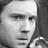

Angry


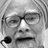

Angry


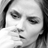

Fear


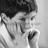

Sad


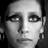

Neutral


In [15]:
for i in xrange(0, 5):
    array = np.mat(data.pixels[i]).reshape(48, 48)
    image = scipy.misc.toimage(array, cmin=0.0)
    display(image)
    print(emotion_labels[data.emotion[i]])

 To be honest, many faces have umbiguous expressions, so our neural network will have hard times classifying them. For example, the first face looks rather surprised or sad, than angry, and the second face doesn't look angry at all. Nevertheless, this is the dataset we have. For the real application I would recommend to collect more samples of higher resolution and then annotate them such that every photo is annotated several times by different independent annotators. Then remove all photos, that were annotated ambiguously.

# Splitting the data

In [16]:
train_set = data[(data.Usage == 'Training')]
test_set = data[(data.Usage != 'Training')]

In [17]:
X_train = np.array(map(str.split, train_set.pixels), np.float32)
X_test = np.array(map(str.split, test_set.pixels), np.float32)

In [18]:
(X_train.shape, X_test.shape)

((28273, 2304), (7067, 2304))

In [19]:
48*48

2304

In [20]:
X_train = X_train.reshape(28273, 48, 48, 1)
X_test = X_test.reshape(7067, 48, 48, 1)

In [21]:
(X_train.shape, X_test.shape)

((28273, 48, 48, 1), (7067, 48, 48, 1))

In [22]:
num_train = X_train.shape[0]
num_test = X_test.shape[0]

In [23]:
(num_train, num_test)

(28273, 7067)

Converting labels to categorical

In [24]:
from keras.utils import np_utils # utilities for one-hot encoding of ground truth values

Using TensorFlow backend.


In [25]:
y_train = train_set.emotion
y_train = np_utils.to_categorical(y_train, num_classes)

In [26]:
y_test = test_set.emotion
y_test = np_utils.to_categorical(y_test, num_classes)

# Data augmentation

In [27]:
batch_size = 32 # in each iteration, we consider 32 training examples at once

In [28]:
from keras.preprocessing.image import ImageDataGenerator 

In [29]:
datagen = ImageDataGenerator(
#     samplewise_center=True,
#     featurewise_center=True,
#     featurewise_std_normalization=True,
    rotation_range=25,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

Compute quantities required for featurewise normalization (std, mean, and principal components if ZCA whitening is applied)

In [30]:
datagen.fit(X_train)

Let's see our images after augmentation

In [31]:
from matplotlib import pyplot

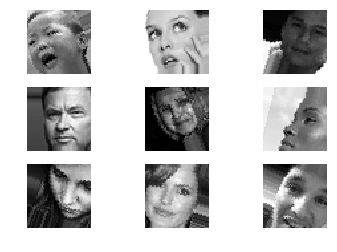

In [32]:
for X_batch, y_batch in datagen.flow(X_train, y_train, batch_size=9):
    # create a grid of 3x3 images
    for i in range(0, 9):
        pyplot.axis('off')
        pyplot.subplot(330 + 1 + i)
        pyplot.imshow(X_batch[i].reshape(48, 48), cmap=pyplot.get_cmap('gray'))
    # show the plot
    pyplot.axis('off')
    pyplot.show()
    break

Generators which provide samples during training.

In [33]:
train_flow = datagen.flow(X_train, y_train, batch_size=batch_size)
test_flow = datagen.flow(X_test, y_test)

In [34]:
# train_set_mean = datagen.mean.reshape(-1)[0]
# train_set_std = datagen.std.reshape(-1)[0]
# print(train_set_mean, train_set_std)

# Creating the network

In [35]:
from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense, BatchNormalization, Conv2D, MaxPool2D

In [36]:
model = Sequential()

model.add(Conv2D(16, (3, 3), padding='same', activation='relu', input_shape=(height, width, depth)))
model.add(Conv2D(16, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D((2,2)))

model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(32, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D((2,2)))

model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D((2,2)))

model.add(Flatten())
model.add(Dense(128))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(num_classes, activation='softmax'))

In [37]:
model.compile(loss='categorical_crossentropy', 
              optimizer='rmsprop',
              metrics=['accuracy'])

In [38]:
model

In [39]:
model.layers

In [40]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 48, 48, 16)        160       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 48, 48, 16)        2320      
_________________________________________________________________
batch_normalization_1 (Batch (None, 48, 48, 16)        64        
_________________________________________________________________
activation_1 (Activation)    (None, 48, 48, 16)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 32)        4640      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 24, 24, 32)        9248      
__________

# Plotting the network structure

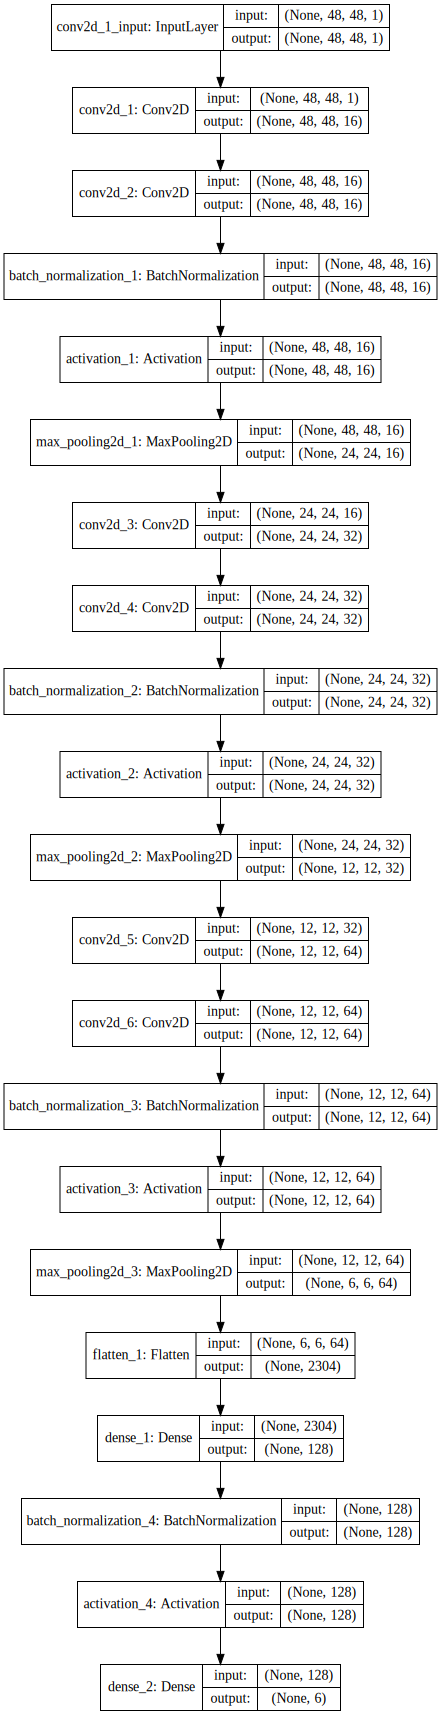

In [41]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

In [42]:
from IPython.display import Image

In [43]:
from keras.utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True, to_file='model.png')

# Training the network

Fit the model on batches with real-time data augmentation:

In [44]:
num_epochs = 100 # we iterate 200 times over the entire training set

In [45]:
history = model.fit_generator(train_flow,
                    steps_per_epoch=len(X_train) / batch_size,
                    epochs=num_epochs, 
                    verbose=1, 
                    validation_data=test_flow, 
                    validation_steps=len(X_test) / batch_size)

Epoch 1/100
883/883 [==============================] - 15s - loss: 1.7065 - acc: 0.2836 - val_loss: 1.8536 - val_acc: 0.1822
Epoch 2/100
883/883 [==============================] - 14s - loss: 1.4980 - acc: 0.4008 - val_loss: 1.5688 - val_acc: 0.3891
Epoch 3/100
883/883 [==============================] - 14s - loss: 1.3902 - acc: 0.4524 - val_loss: 1.5241 - val_acc: 0.4038
Epoch 4/100
883/883 [==============================] - 14s - loss: 1.3157 - acc: 0.4822 - val_loss: 1.4682 - val_acc: 0.4384
Epoch 5/100
883/883 [==============================] - 13s - loss: 1.2714 - acc: 0.5035 - val_loss: 1.3402 - val_acc: 0.5055
Epoch 6/100
883/883 [==============================] - 14s - loss: 1.2269 - acc: 0.5219 - val_loss: 1.3861 - val_acc: 0.4662
Epoch 7/100
883/883 [==============================] - 14s - loss: 1.2020 - acc: 0.5325 - val_loss: 1.5129 - val_acc: 0.4270
Epoch 8/100
883/883 [==============================] - 14s - loss: 1.1779 - acc: 0.5414 - val_loss: 1.3137 - val_acc: 0.4897


883/883 [==============================] - 13s - loss: 0.9621 - acc: 0.6373 - val_loss: 1.1647 - val_acc: 0.5804
Epoch 67/100
883/883 [==============================] - 13s - loss: 0.9606 - acc: 0.6358 - val_loss: 1.1055 - val_acc: 0.5822
Epoch 68/100
883/883 [==============================] - 13s - loss: 0.9570 - acc: 0.6393 - val_loss: 1.1140 - val_acc: 0.5945
Epoch 69/100
883/883 [==============================] - 13s - loss: 0.9494 - acc: 0.6417 - val_loss: 1.0465 - val_acc: 0.6031
Epoch 70/100
883/883 [==============================] - 13s - loss: 0.9552 - acc: 0.6376 - val_loss: 1.0701 - val_acc: 0.6139
Epoch 71/100
883/883 [==============================] - 13s - loss: 0.9542 - acc: 0.6390 - val_loss: 1.0962 - val_acc: 0.5844
Epoch 72/100
883/883 [==============================] - 13s - loss: 0.9590 - acc: 0.6376 - val_loss: 1.0587 - val_acc: 0.6064
Epoch 73/100
883/883 [==============================] - 13s - loss: 0.9462 - acc: 0.6412 - val_loss: 1.0419 - val_acc: 0.6173
Epoch

# Plotting loss

In [46]:
from matplotlib import pyplot as plt

In [76]:
history.history.keys()

['acc', 'loss', 'val_acc', 'val_loss']

history for accuracy

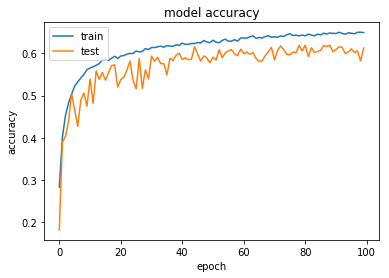

In [77]:
# plt.figure(figsize=(5.5, 2.5), dpi=300)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
# plt.savefig("accuracy.png", bbox_inches='tight')
plt.show()

history for loss

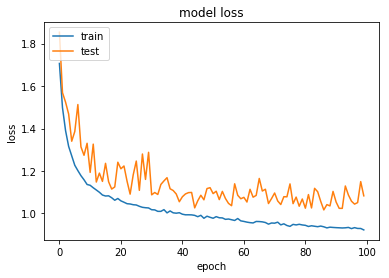

In [78]:
# plt.figure(figsize=(5.5, 2.5), dpi=300)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
# plt.savefig("loss.png", bbox_inches='tight')
plt.show()

# Making predictions

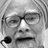

Angry


In [48]:
array = np.mat(data.pixels[1]).reshape(48, 48)
image = scipy.misc.toimage(array, cmin=0.0)
display(image)
print(emotion_labels[data.emotion[1]])

In [49]:
input_img = np.array(array).reshape(1,48,48,1)

In [52]:
prediction = model.predict(input_img)
print(prediction)

[[ 0.05708674  0.35863262  0.03299783  0.17862292  0.00069717  0.37196276]]


In [53]:
emotion_labels[prediction.argmax()]

'Neutral'

Let's classify first 100 faces.

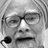

Angry
Neutral


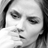

Fear
Sad


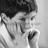

Sad
Sad


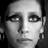

Neutral
Neutral


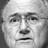

Fear
Sad


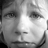

Sad
Sad


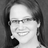

Happy
Happy


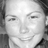

Happy
Happy


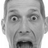

Fear
Fear


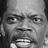

Angry
Angry


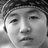

Neutral
Neutral


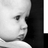

Neutral
Sad


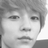

Neutral
Neutral


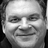

Happy
Happy


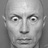

Surprise
Surprise


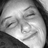

Happy
Happy


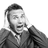

Fear
Happy


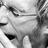

Neutral
Sad


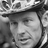

Sad
Happy


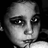

Sad
Sad


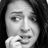

Fear
Fear


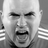

Angry
Angry


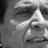

Angry
Happy


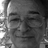

Happy
Happy


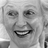

Happy
Happy


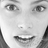

Surprise
Surprise


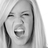

Angry
Angry


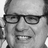

Happy
Happy


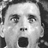

Surprise
Surprise


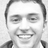

Happy
Happy


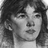

Neutral
Angry


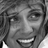

Happy
Happy


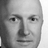

Fear
Neutral


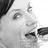

Happy
Happy


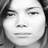

Neutral
Neutral


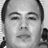

Neutral
Neutral


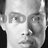

Neutral
Neutral


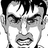

Angry
Angry


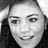

Surprise
Happy


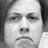

Angry
Angry


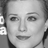

Happy
Happy


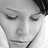

Sad
Sad


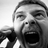

Angry
Fear


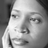

Neutral
Neutral


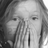

Fear
Fear


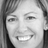

Happy
Happy


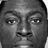

Neutral
Neutral


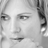

Fear
Neutral


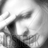

Fear
Sad


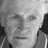

Fear
Neutral


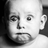

Surprise
Surprise


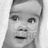

Surprise
Surprise


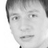

Neutral
Surprise


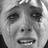

Sad
Happy


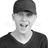

Surprise
Fear


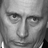

Angry
Angry


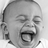

Happy
Happy


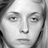

Sad
Neutral


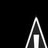

Fear
Sad


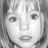

Neutral
Neutral


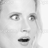

Surprise
Surprise


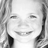

Happy
Happy


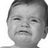

Sad
Sad


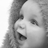

Happy
Happy


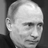

Angry
Angry


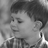

Sad
Angry


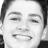

Happy
Happy


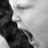

Angry
Sad


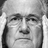

Surprise
Angry


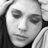

Sad
Sad


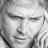

Fear
Sad


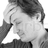

Sad
Sad


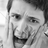

Fear
Fear


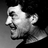

Angry
Angry


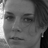

Neutral
Neutral


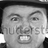

Angry
Angry


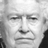

Angry
Angry


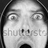

Surprise
Surprise


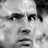

Sad
Angry


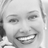

Happy
Happy


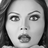

Surprise
Surprise


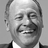

Happy
Happy


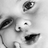

Neutral
Neutral


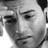

Fear
Sad


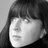

Fear
Sad


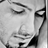

Sad
Sad


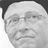

Sad
Happy


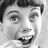

Surprise
Surprise


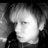

Sad
Sad


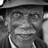

Angry
Neutral


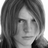

Angry
Neutral


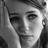

Neutral
Neutral


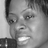

Angry
Happy


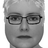

Neutral
Neutral


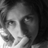

Fear
Fear


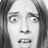

Fear
Fear


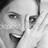

Happy
Happy


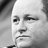

Sad
Angry


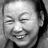

Happy
Happy


In [54]:
for i in xrange(1, 100):
    array = np.mat(data.pixels[i]).reshape(48, 48)
    image = scipy.misc.toimage(array, cmin=0.0)
    display(image)
    print(emotion_labels[data.emotion[i]])
    input_img = np.array(array).reshape(1,48,48,1)
    prediction = model.predict(input_img)
    print(emotion_labels[prediction.argmax()])

# Evaluating the trained model on the test set

In [55]:
model.evaluate_generator(test_flow, steps=len(X_test) / batch_size)

[1.1285726155553546, 0.60696517426491459]

# Saving the model in HDF5 format

In [1]:
from keras.models import load_model

Using TensorFlow backend.


Documentation: https://keras.io/getting-started/faq/#how-can-i-save-a-keras-model

In [57]:
model.save('Emotions.h5')

# Converting to Core ML format

In [2]:
model = load_model('Emotions.h5')

/Users/Oleksandr/coreml/lib/python2.7/site-packages/keras/models.py:281: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


In [3]:
from coremltools.converters.keras import convert

Documentation: http://pythonhosted.org/coremltools/generated/coremltools.converters.keras.convert.html

In [8]:
coreml_model = convert(model,
                       input_names = 'Image',
                       image_input_names = 'Image',
                       output_names = 'Facial Expression',
                       class_labels = emotion_labels,
                       predicted_feature_name = 'FacialExpression')

0 : conv2d_1_input, <keras.engine.topology.InputLayer object at 0x1130d1a50>
1 : conv2d_1, <keras.layers.convolutional.Conv2D object at 0x1130d1a90>
2 : conv2d_1__activation__, <keras.layers.core.Activation object at 0x115bc5950>
3 : conv2d_2, <keras.layers.convolutional.Conv2D object at 0x113110fd0>
4 : batch_normalization_1, <keras.layers.normalization.BatchNormalization object at 0x113169390>
5 : activation_1, <keras.layers.core.Activation object at 0x1130d1e50>
6 : max_pooling2d_1, <keras.layers.pooling.MaxPooling2D object at 0x1130d1f50>
7 : conv2d_3, <keras.layers.convolutional.Conv2D object at 0x11314a790>
8 : conv2d_3__activation__, <keras.layers.core.Activation object at 0x115c17590>
9 : conv2d_4, <keras.layers.convolutional.Conv2D object at 0x1132535d0>
10 : batch_normalization_2, <keras.layers.normalization.BatchNormalization object at 0x113296d90>
11 : activation_2, <keras.layers.core.Activation object at 0x113376350>
12 : max_pooling2d_2, <keras.layers.pooling.MaxPooling2D

In [9]:
coreml_model.save('Emotions.mlmodel')

# Visualizing convolution filters

pip install keras-vis

https://raghakot.github.io/keras-vis/visualizations/conv_filters/

In [62]:
from vis.utils import utils
from vis.visualization import visualize_activation, get_num_filters

We have to convert grayscale images to rgb to use them with keras-vis

In [63]:
# source: http://www.socouldanyone.com/2013/03/converting-grayscale-to-rgb-with-numpy.html
def to_rgb(im):
    # I think this will be slow
    w, h = im.shape
    ret = np.empty((w, h, 3), dtype=np.uint8)
    ret[:, :, 0] = im
    ret[:, :, 1] = im
    ret[:, :, 2] = im
    return ret

In [64]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 48, 48, 16)        160       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 48, 48, 16)        2320      
_________________________________________________________________
batch_normalization_1 (Batch (None, 48, 48, 16)        64        
_________________________________________________________________
activation_1 (Activation)    (None, 48, 48, 16)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 32)        4640      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 24, 24, 32)        9248      
__________

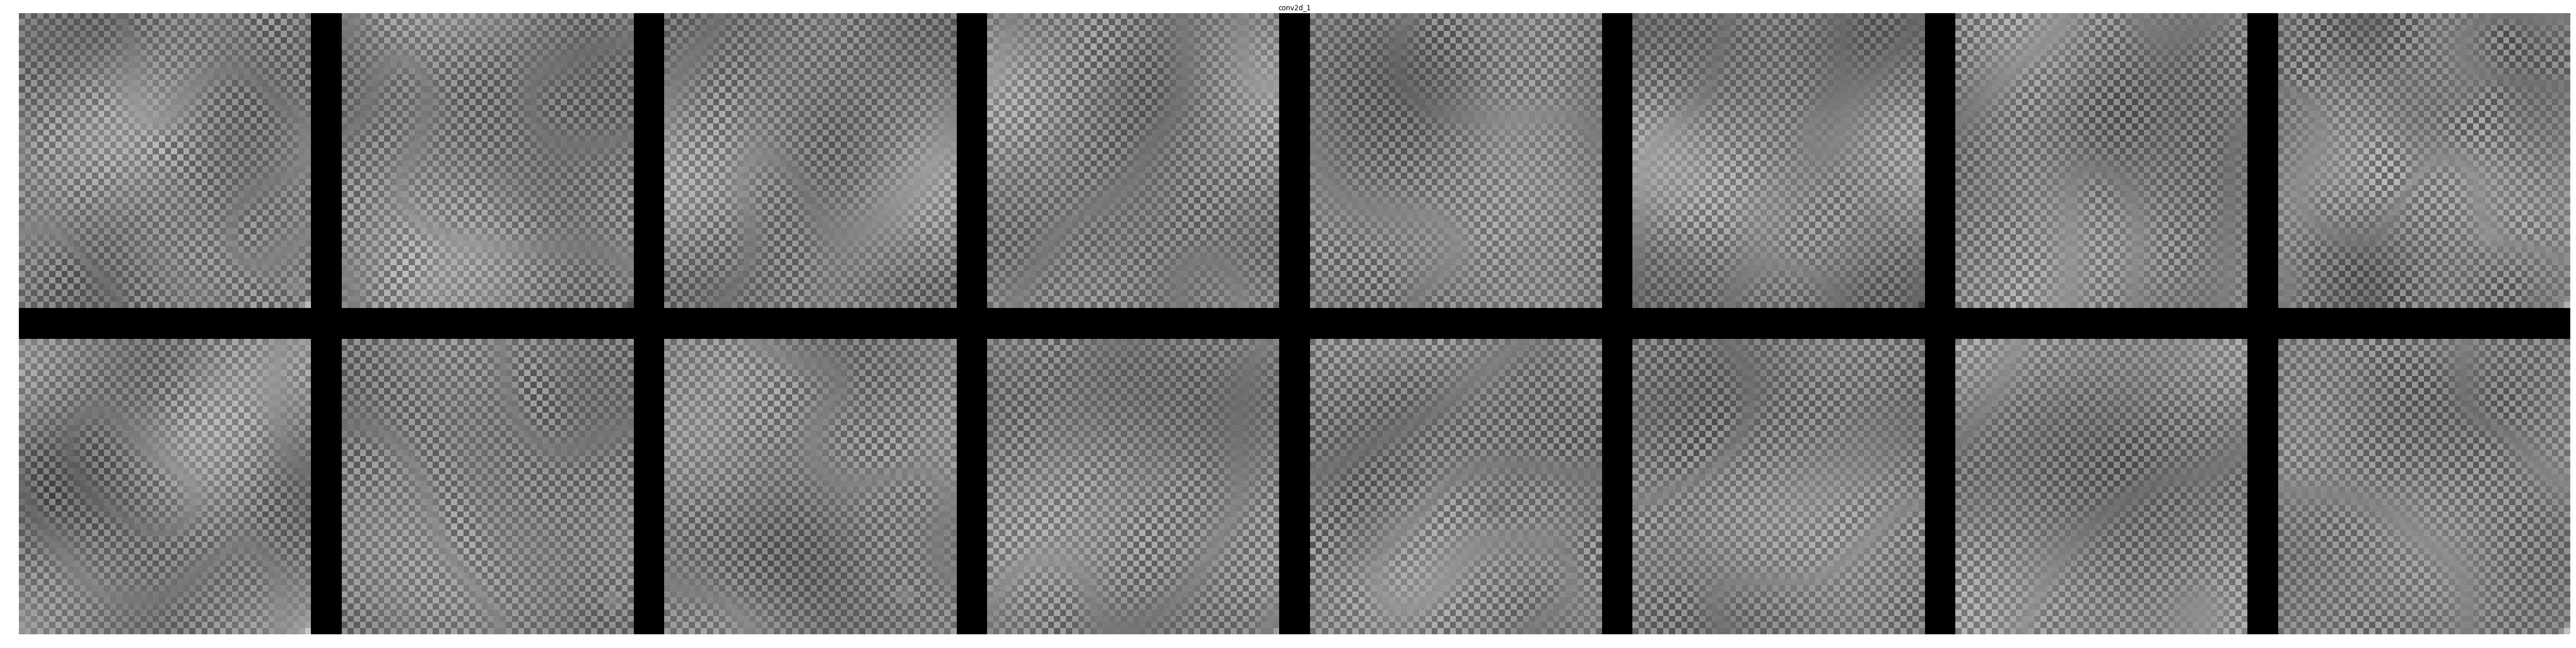

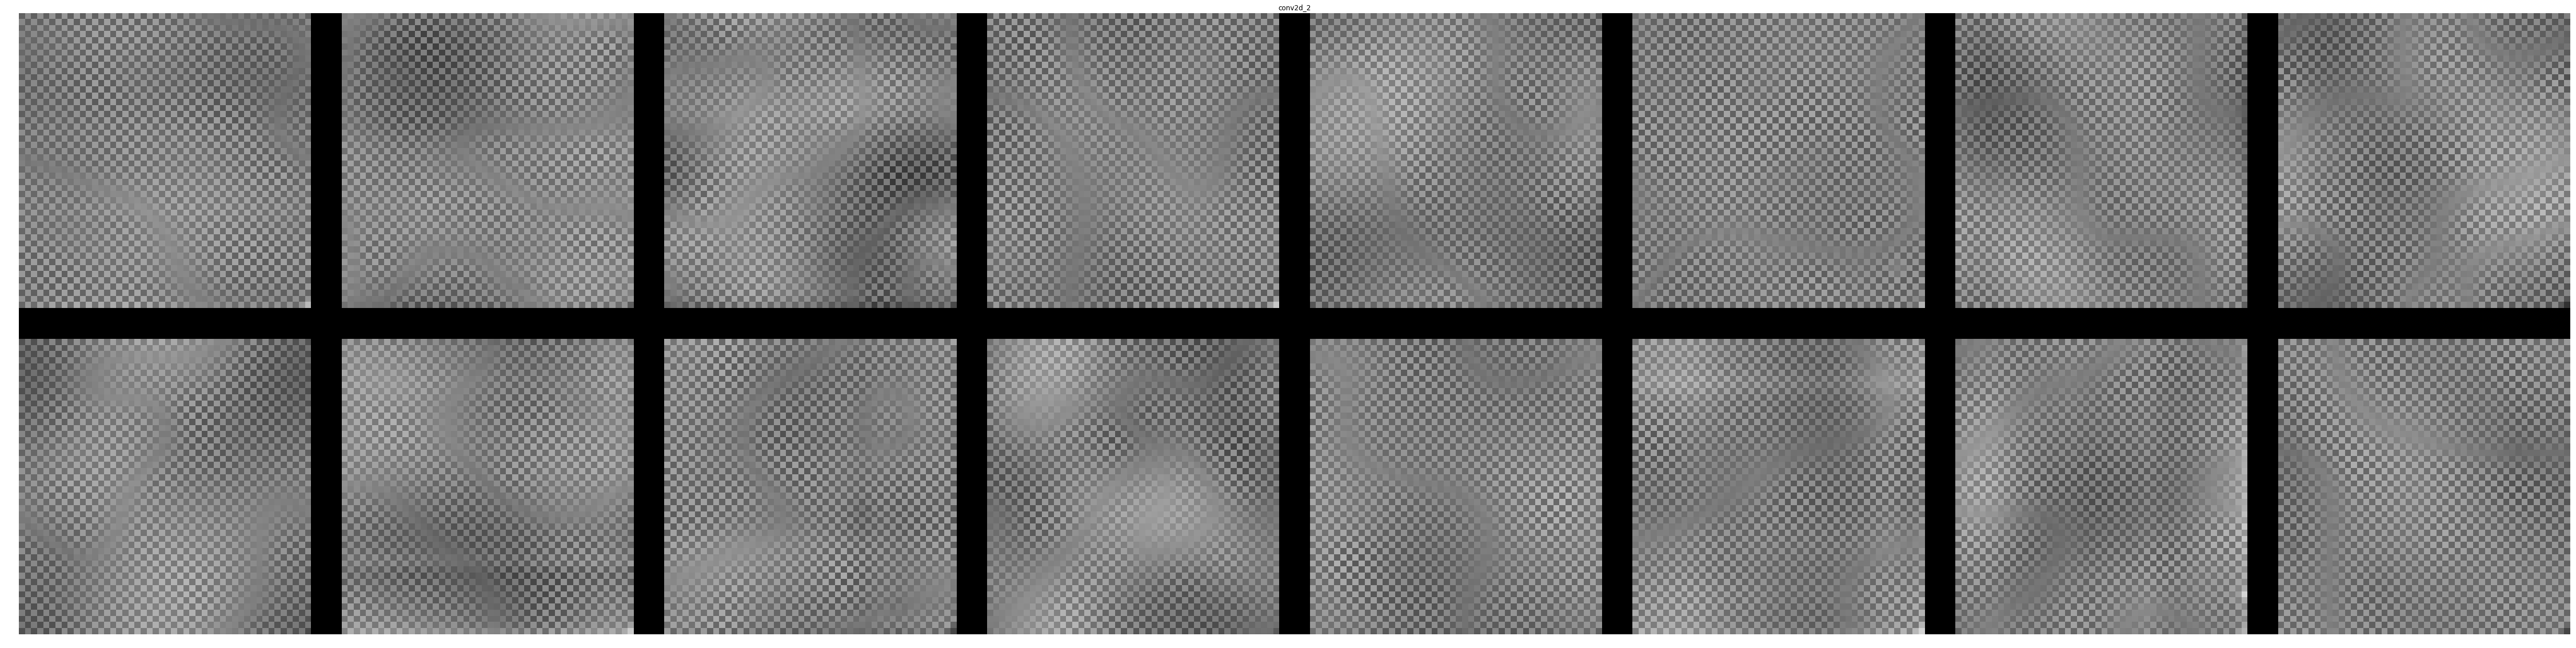

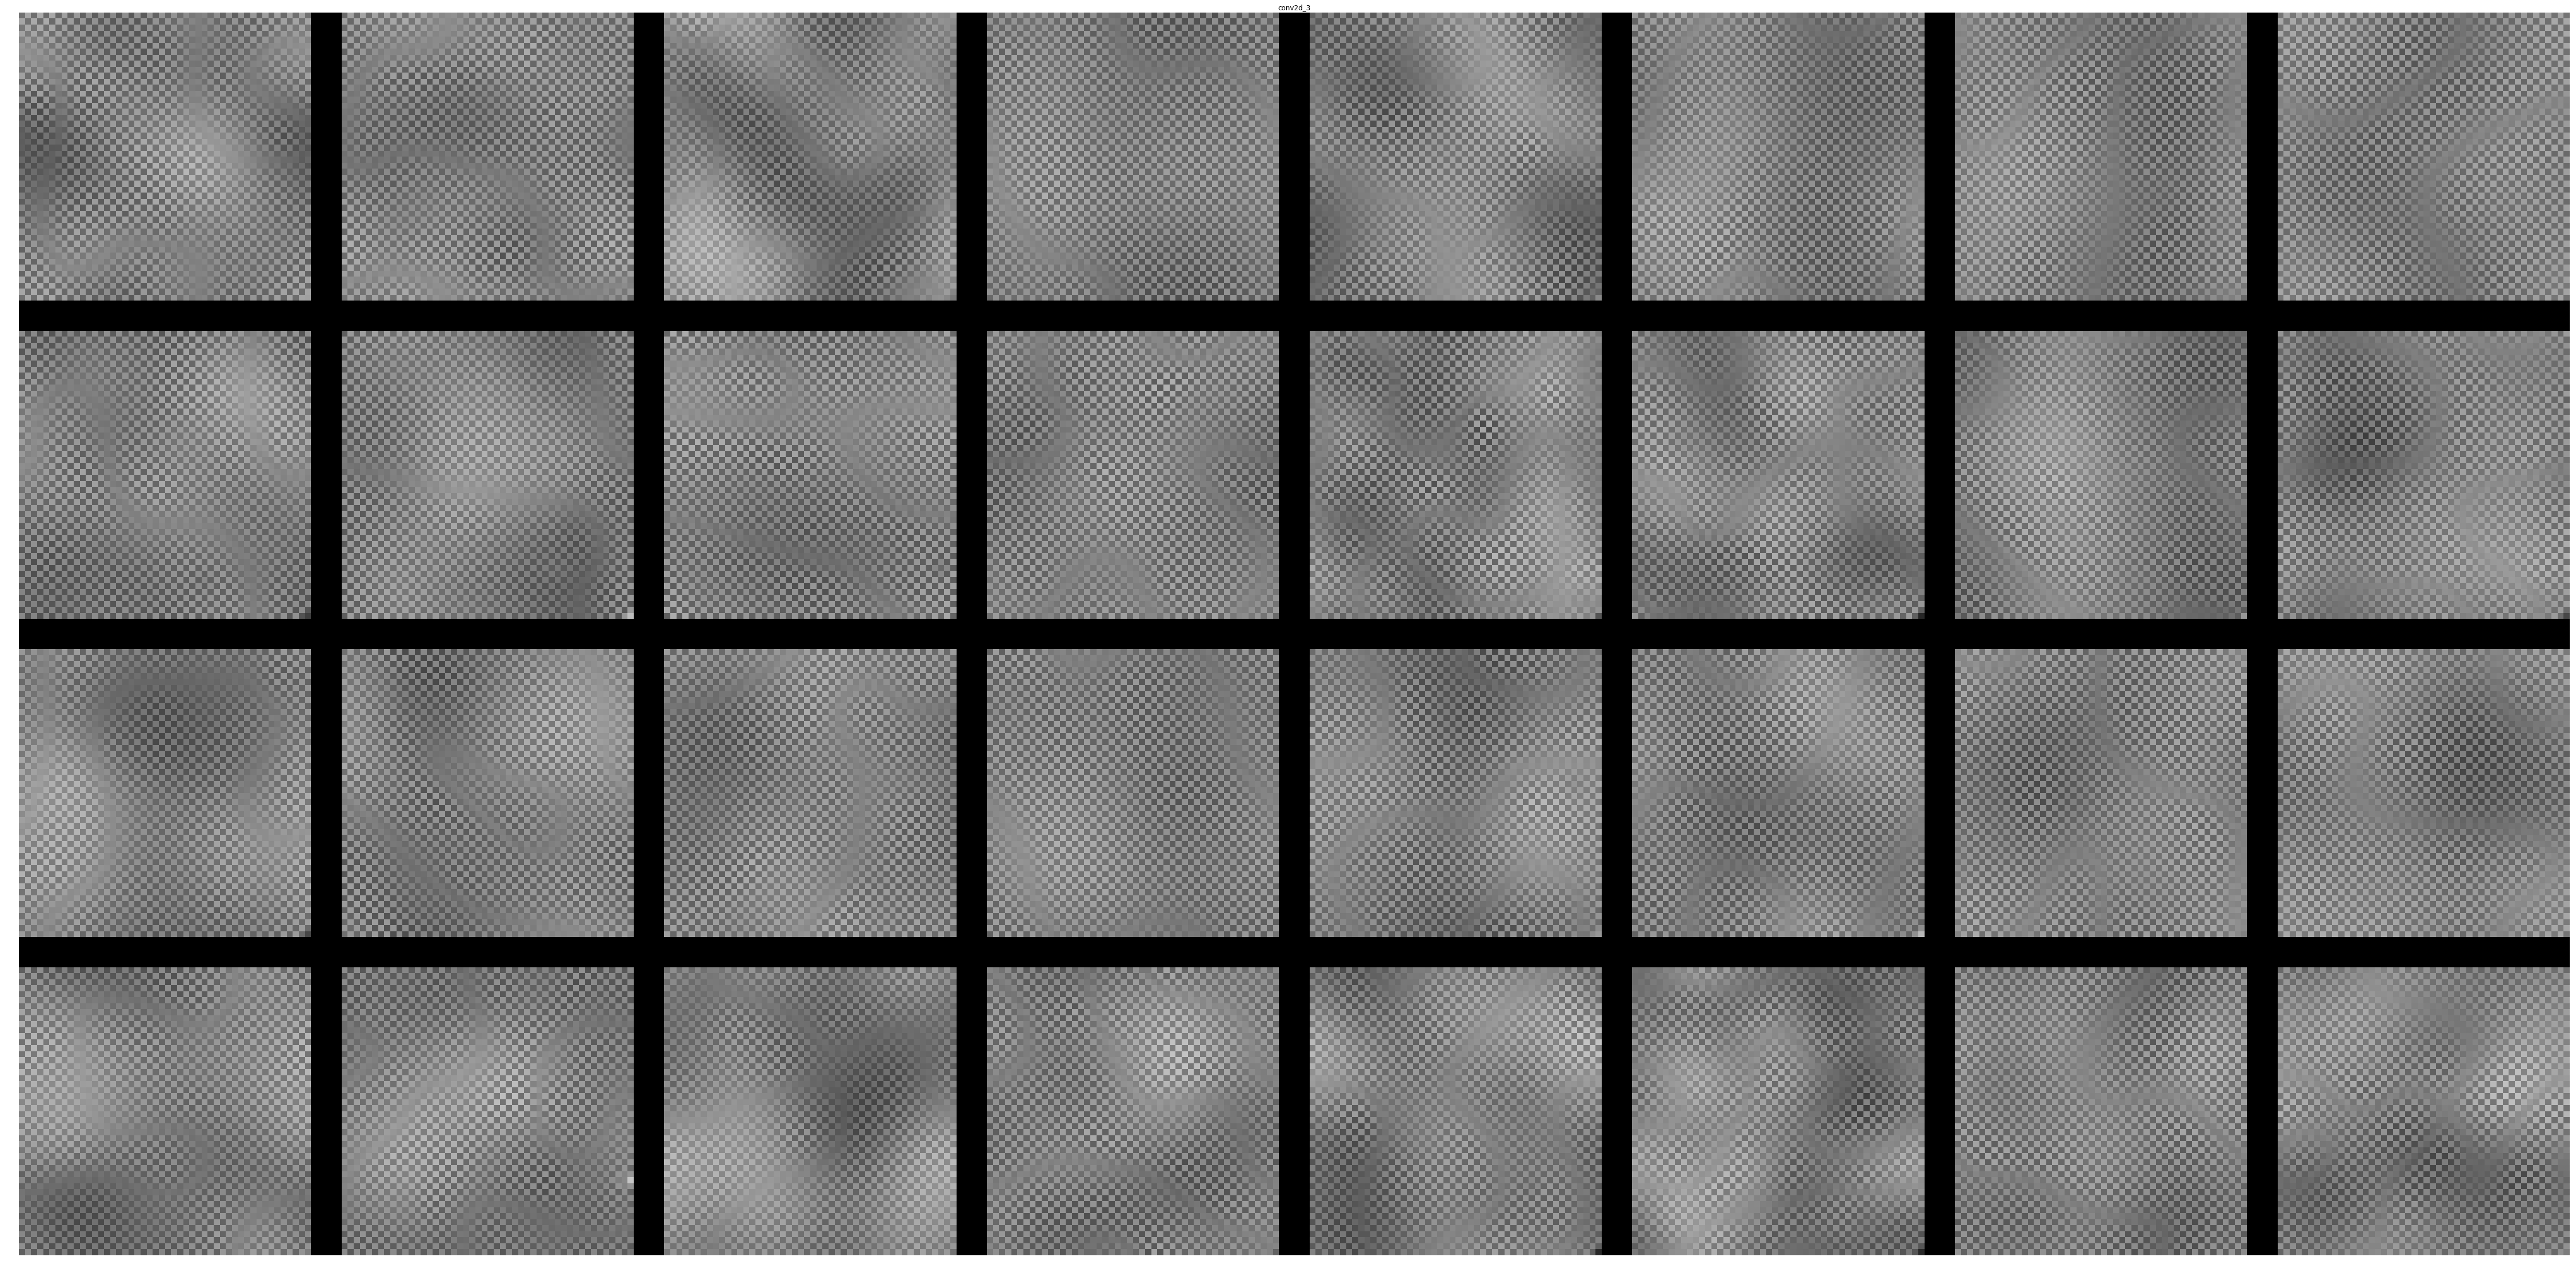

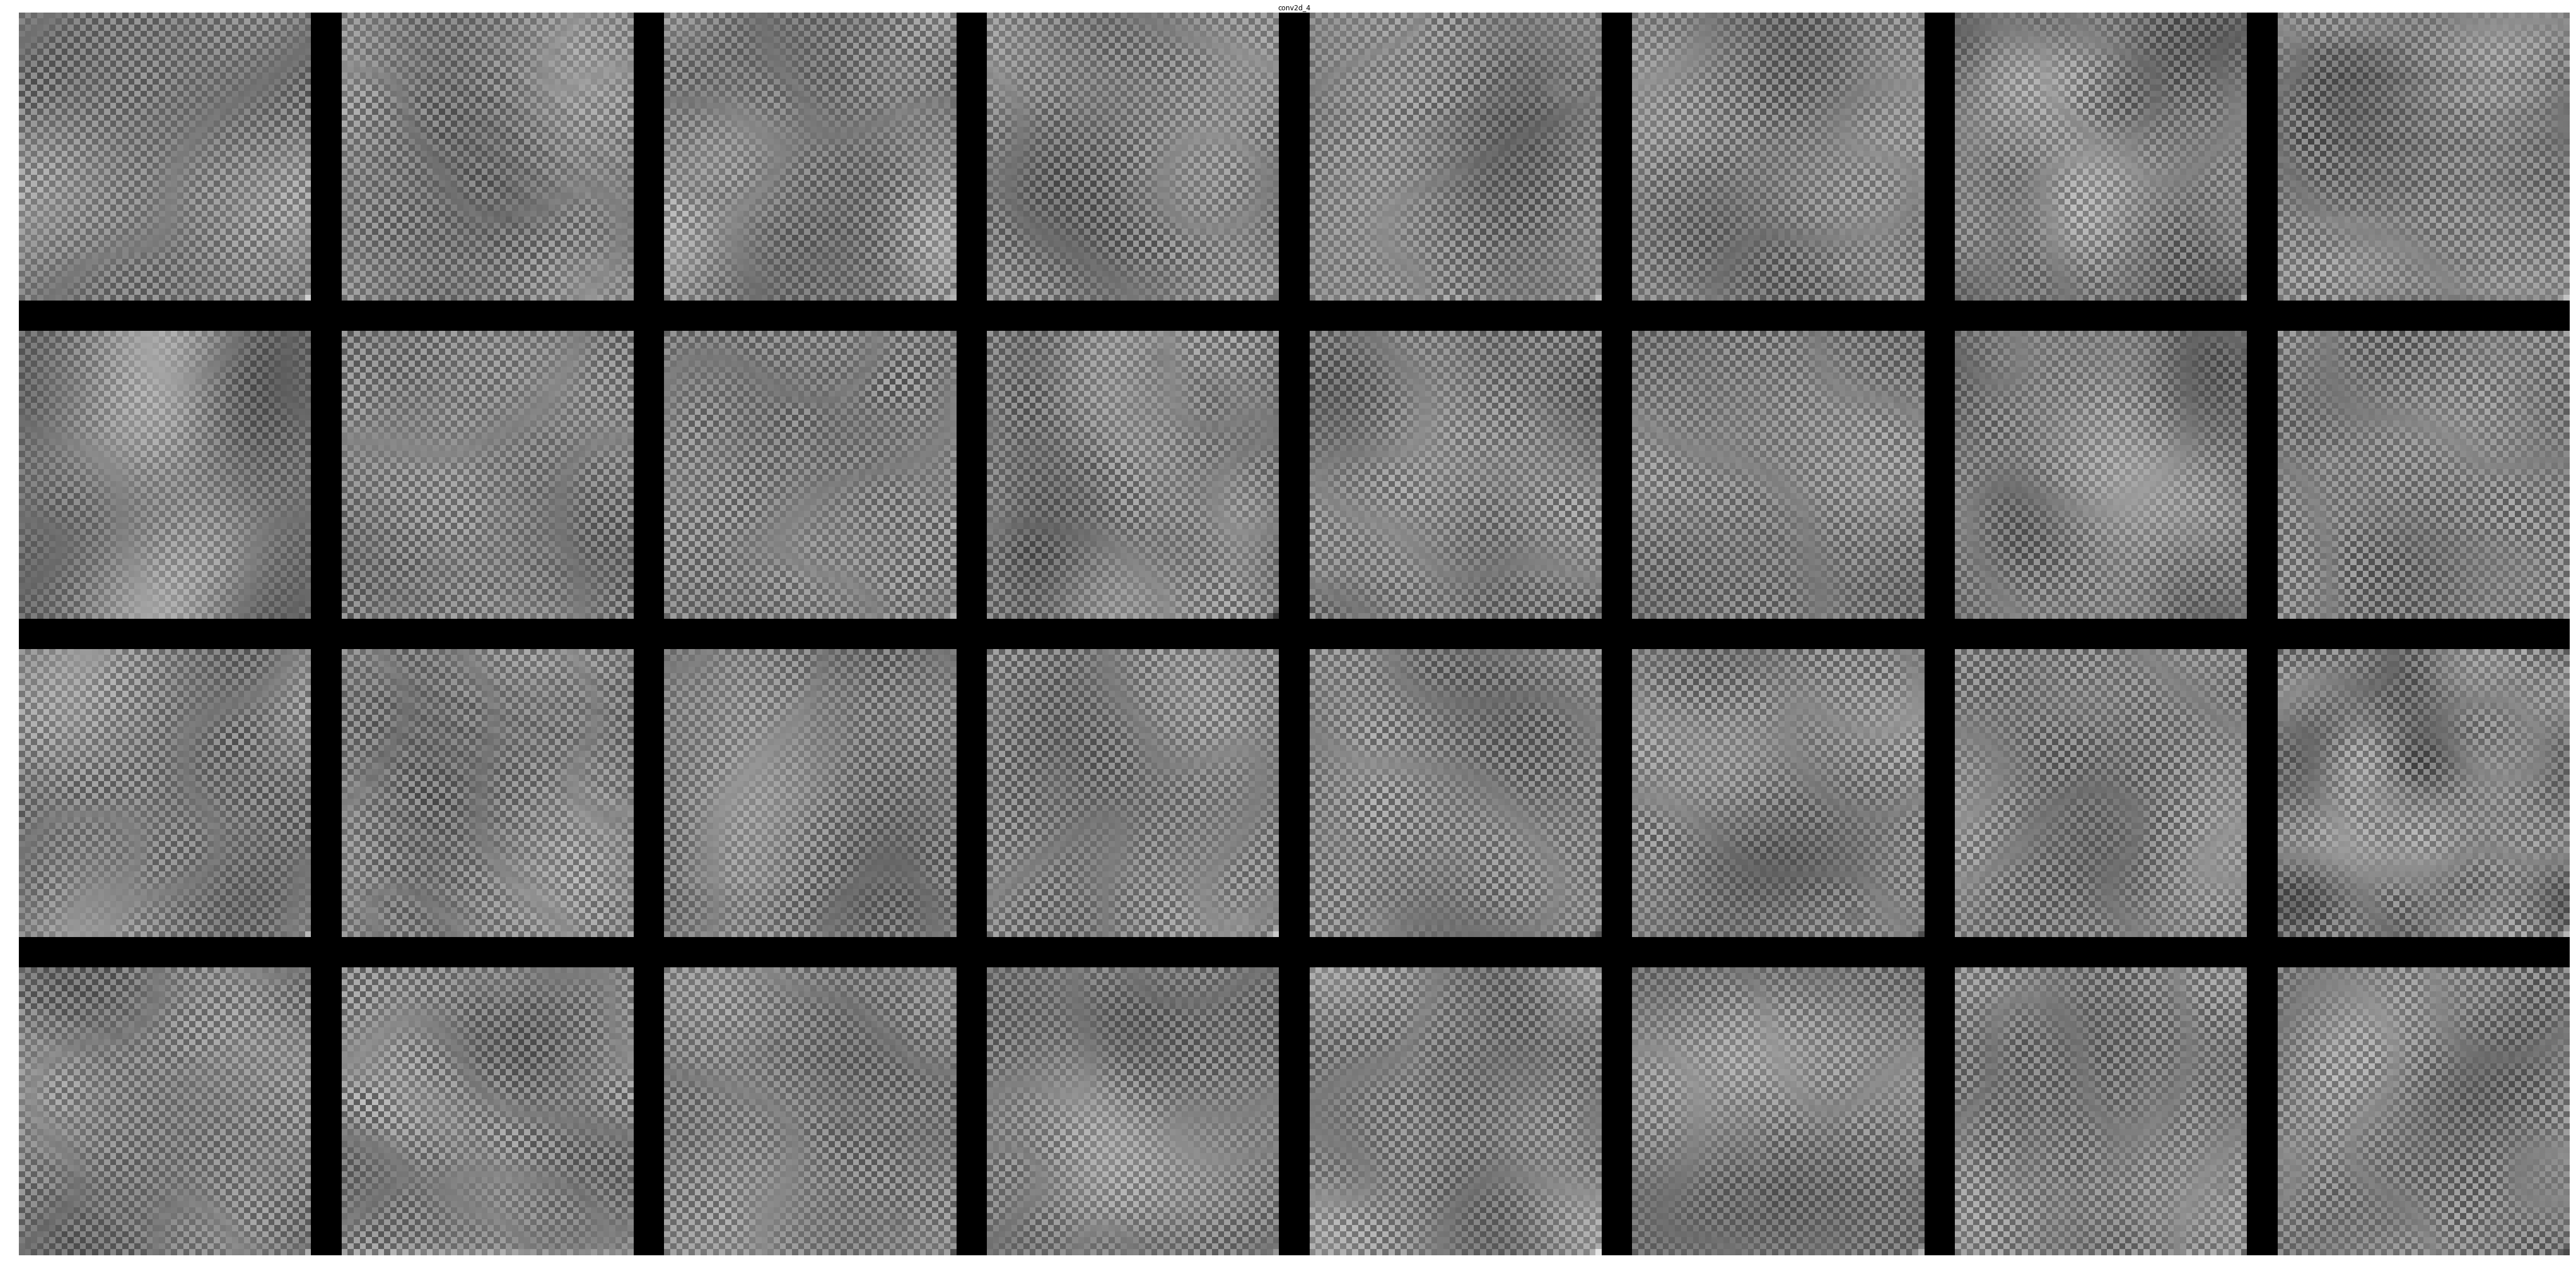

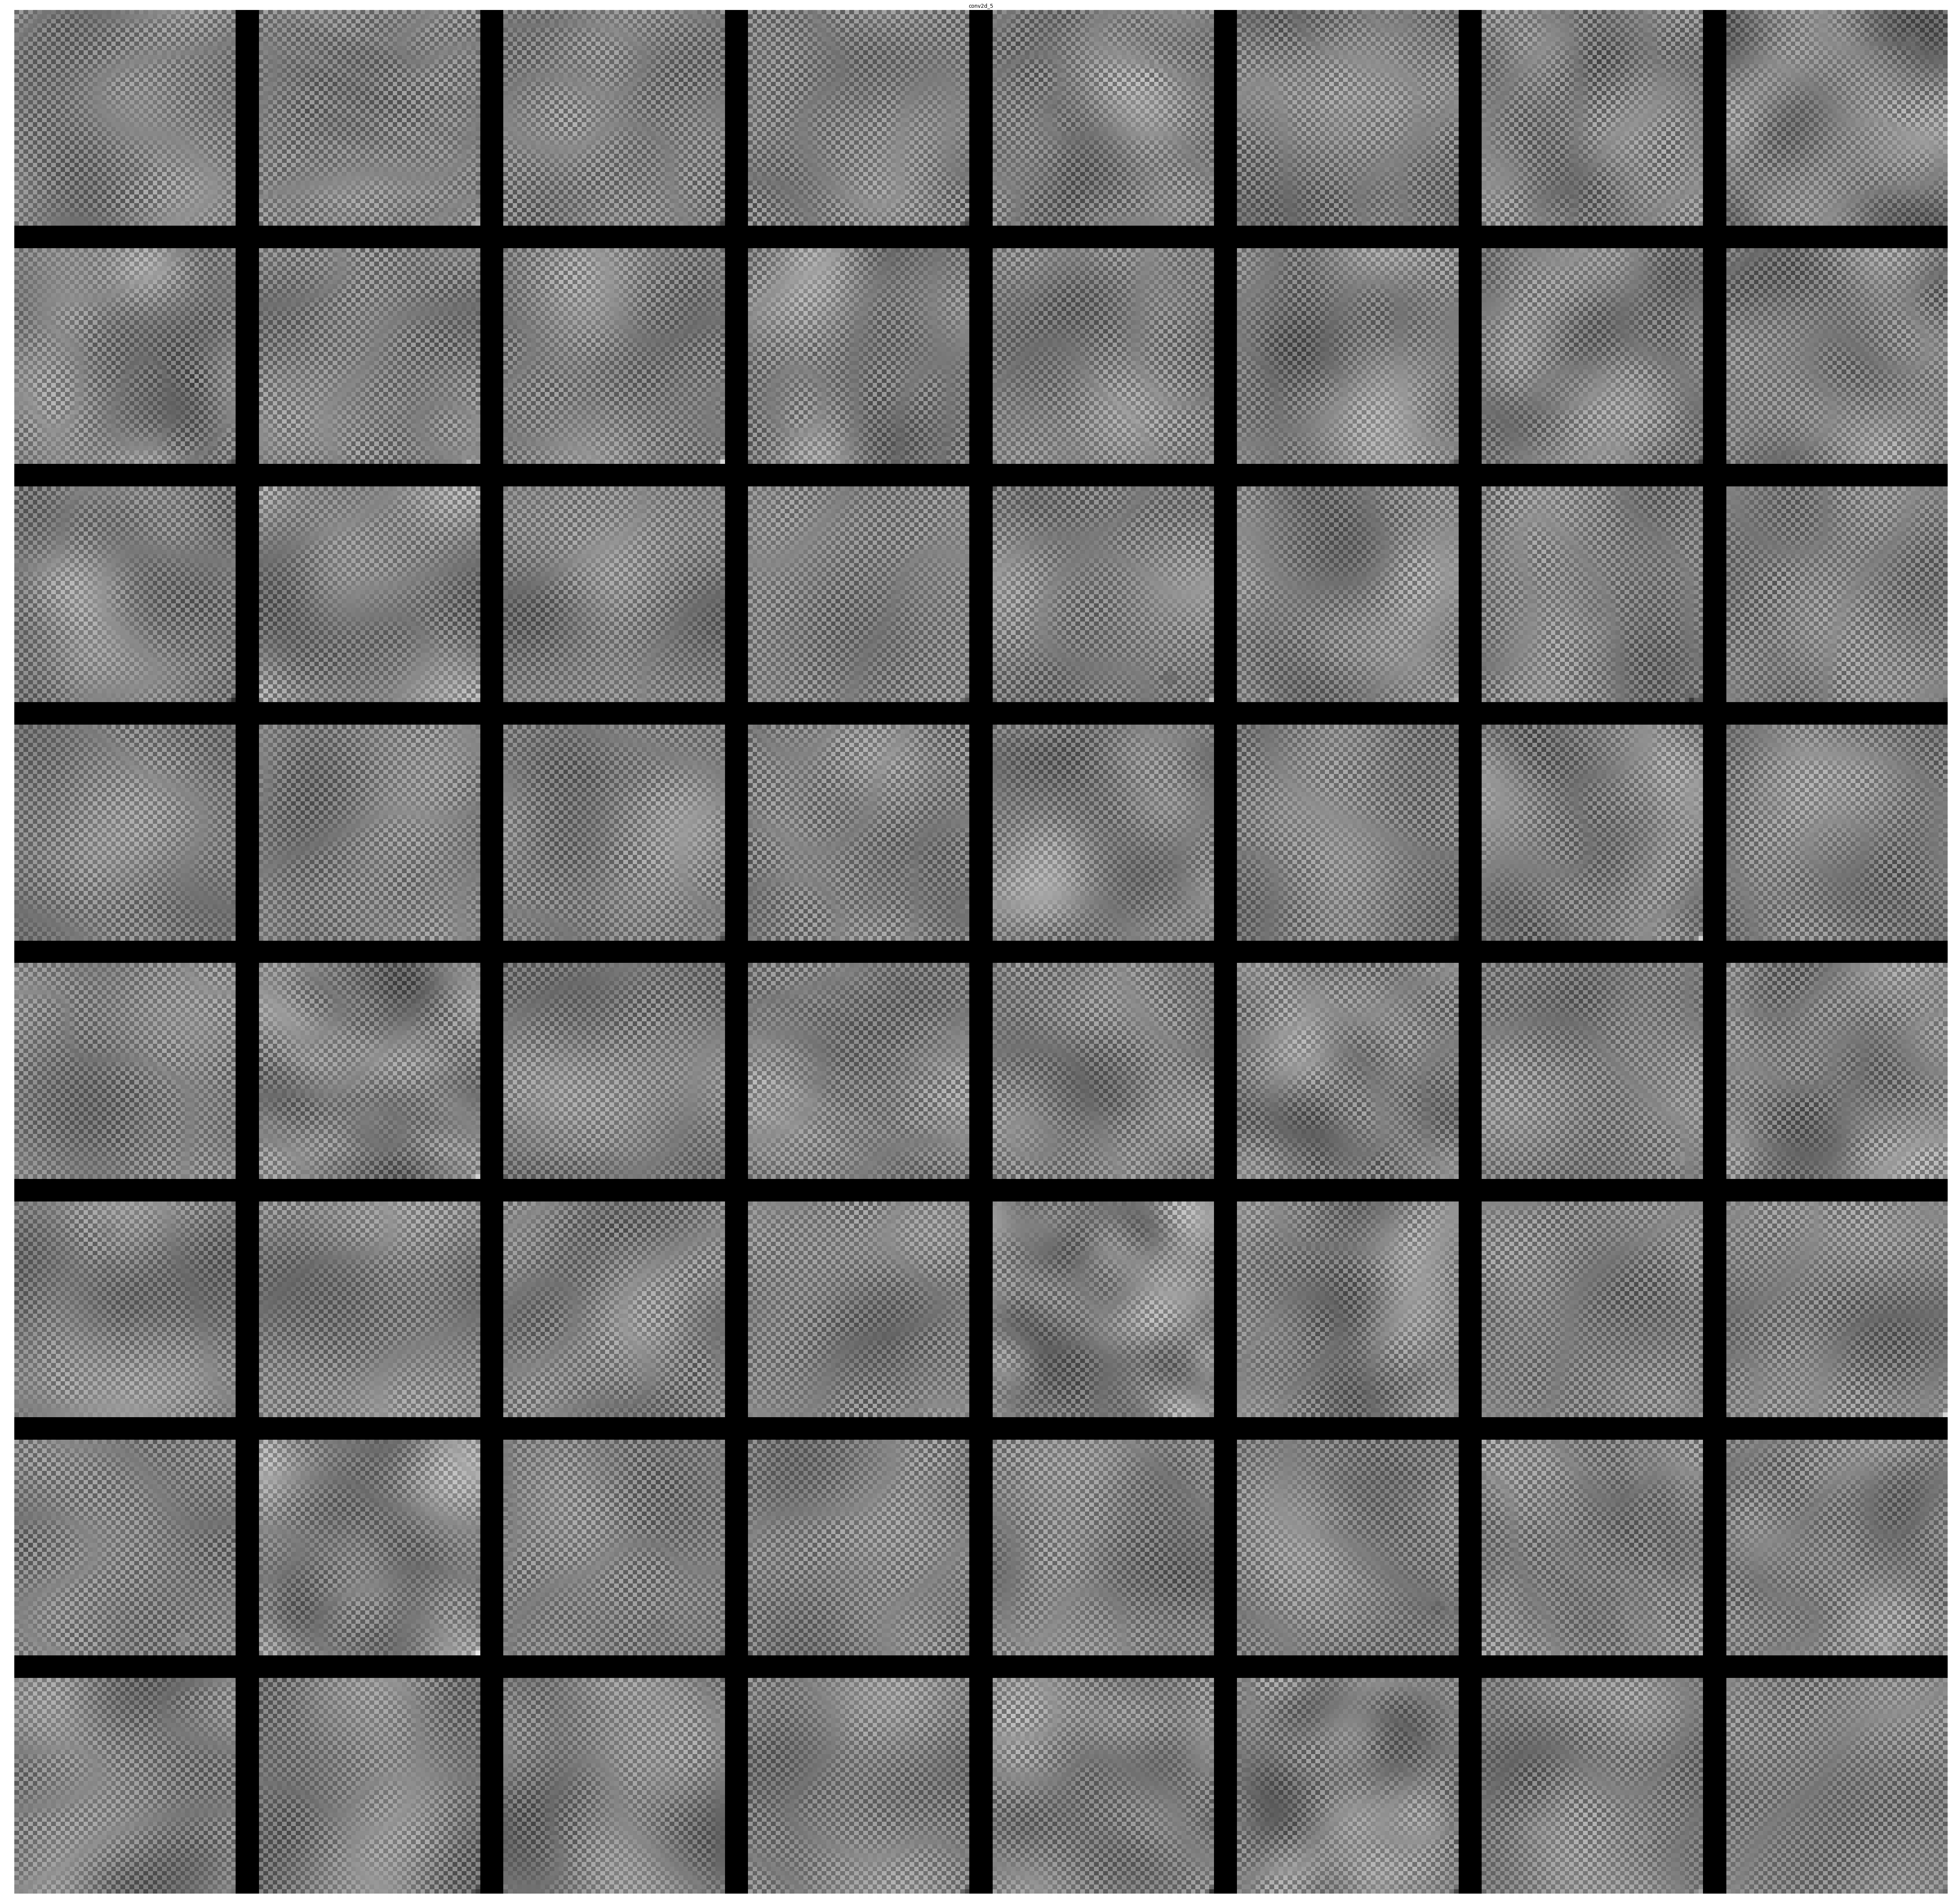

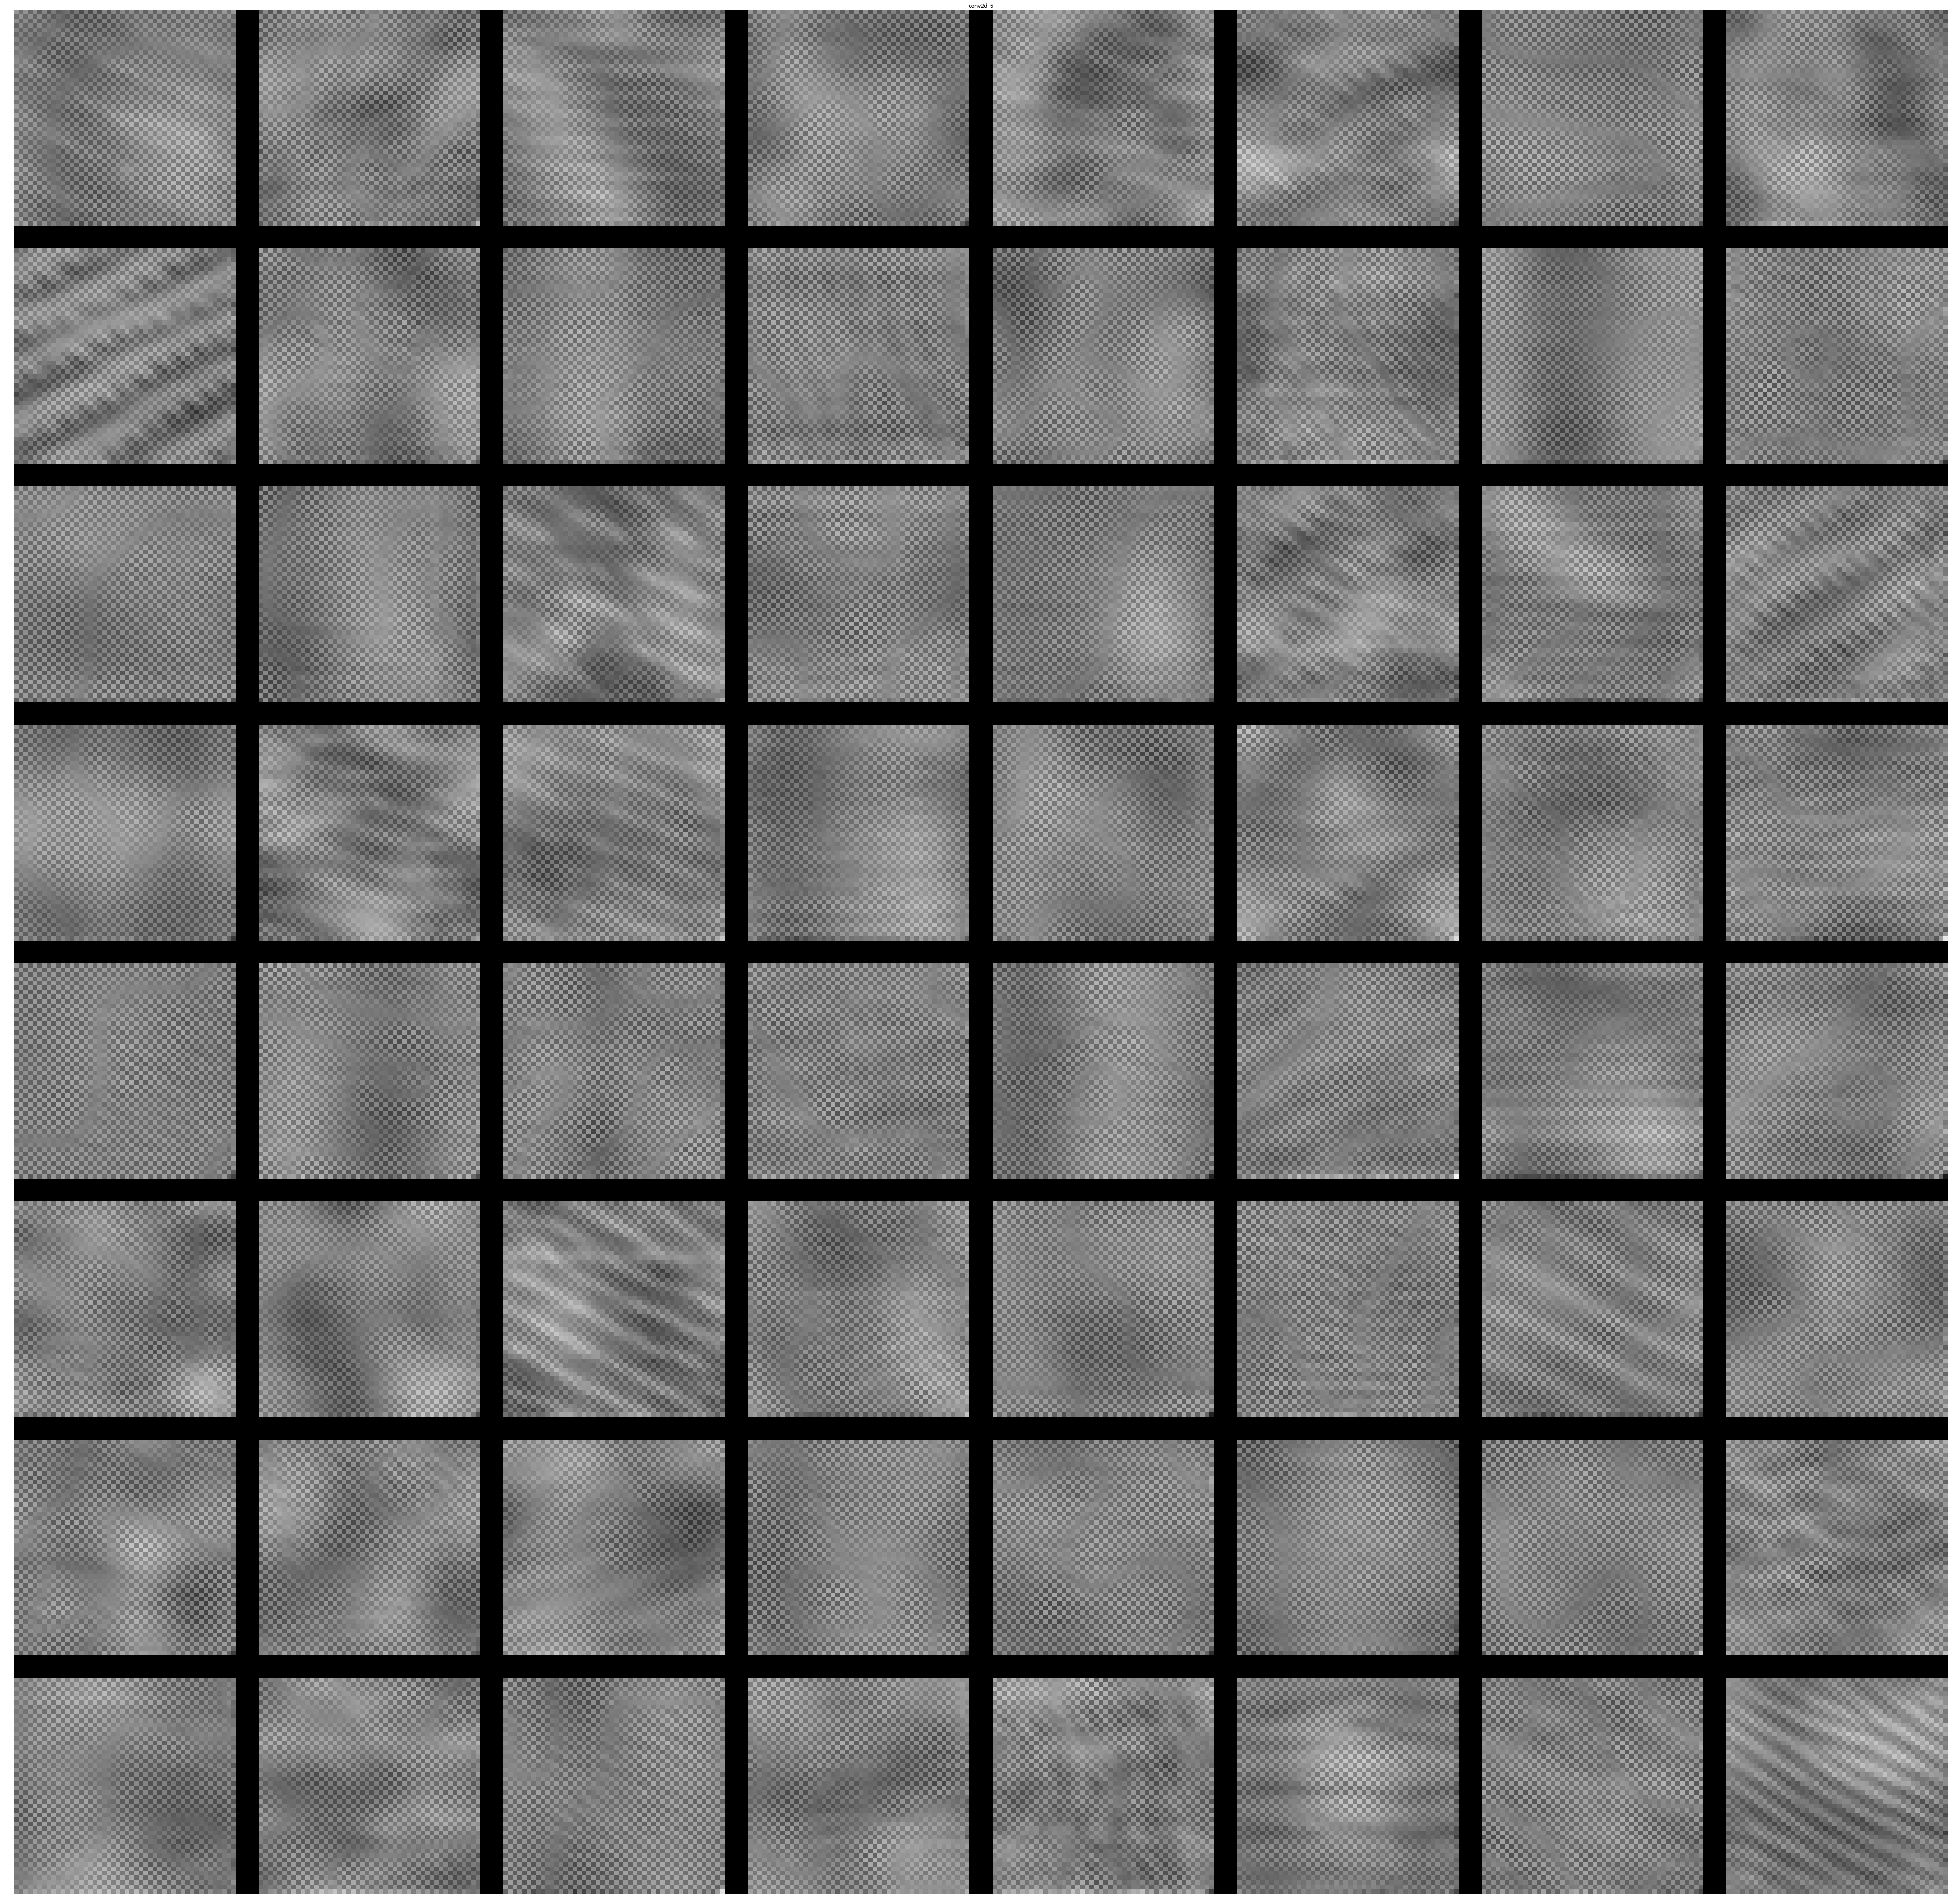

In [65]:
# Names of the layers we want to visualize
layer_names = ['conv2d_1', 'conv2d_2', 
               'conv2d_3', 'conv2d_4', 
               'conv2d_5', 'conv2d_6']

layer_sizes = [(80, 20), (80, 20), 
               (80, 40), (80, 40), 
               (80, 80), (80, 80)]

stitched_figs = []

for (layer_name, layer_size) in zip(layer_names, layer_sizes):
    layer_idx = [idx for idx, layer in enumerate(model.layers) if layer.name == layer_name][0]

    # Visualize all filters in this layer.
    filters = np.arange(get_num_filters(model.layers[layer_idx]))

    # Generate input image for each filter. Here `text` field is used to overlay `filter_value` on top of the image.
    vis_images = []
    for idx in filters:
        img = visualize_activation(model, layer_idx, filter_indices=idx) 
        vis_images.append(to_rgb(img.reshape(48,48)))

    # Generate stitched image palette with 8 cols.
    stitched = utils.stitch_images(vis_images, cols=8)
    stitched_figs.append(stitched)
    
    plt.figure(figsize = layer_size)
    plt.axis('off')
    plt.imshow(stitched, interpolation='nearest', aspect='auto')
    plt.title(layer_name)
    plt.savefig(layer_name+"_filters.png", bbox_inches='tight')
    plt.show()

# Saving (pickling) and loading python objects

In [6]:
# import cPickle

In [31]:
# with open('imgfile','w') as f:
#     cPickle.dump(vis_images_to_display,f)

In [32]:
# with open('filtersfile','w') as f:
#     cPickle.dump(vis_images,f)

In [9]:
# vis_images_to_display = cPickle.load(open('imgfile', 'rb'))
# vis_images = cPickle.load(open('filtersfile', 'rb'))

# Visualizing convolution filters from VGG16

VGG16: https://gist.github.com/baraldilorenzo/07d7802847aaad0a35d3

In [37]:
import numpy as np
from matplotlib import pyplot as plt

from vis.utils import utils
from keras.applications.vgg16 import VGG16
from vis.visualization import visualize_activation, get_num_filters

# Build the VGG16 network with ImageNet weights
model = VGG16(weights='imagenet', include_top=True)
print('Model loaded.')

# The name of the layer we want to visualize
# (see model definition in vggnet.py)
layer_name = 'block2_conv2'
layer_idx = [idx for idx, layer in enumerate(model.layers) if layer.name == layer_name][0]

# Visualize all filters in this layer.
filters = np.arange(get_num_filters(model.layers[layer_idx]))

# Generate input image for each filter. Here `text` field is used to overlay `filter_value` on top of the image.
vis_images = []
for idx in filters:
    img = visualize_activation(model, layer_idx, filter_indices=idx) 
    img = utils.draw_text(img, str(idx))
    vis_images.append(img)

Model loaded.


In [42]:
# Generate stitched image palette with 8 cols.
stitched = utils.stitch_images(vis_images, cols=8)
plt.figure(figsize = (40,80))
plt.axis('off')
plt.imshow(stitched, interpolation='nearest', aspect='auto')
plt.title(layer_name)
plt.savefig(layer_name+"_vgg16.png", bbox_inches='tight')
# plt.show()

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.
